Detection of key points of the face.
Create a convolutional network that identifies points on the face.

In [ ]:
#initialize the modules
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from google.colab import files
import io
import pandas as pd

In [ ]:
#connecting modules for working with Google Collab - for loading the training dataset
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')
path='/content/gdrive/MyDrive/data/wum4/training.csv'#training dataset
train_data = pd.read_csv(path)

Mounted at /content/gdrive


The data is in the facekeypoints folder. Data is in the facekeypoints folder. The first 30 columns contain coordinates of points on the face. The 31st column contains a black and white representation of the image. Display in python several sample images (plt.imshow) together with dots (plt.scatter). The size of the image is 96 x 96

The first 30 columns contain the coordinates of the points on the face. The 31st column contains a black and white representation of the image. Display in python several sample images (plt.imshow) together with dots (plt.scatter). The size of the image is 96 x 96

In [ ]:

IMG_SIZE = 96 #image size parameter

def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], marker ='.', c='b')

def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):#photo display function
    plt.figure(figsize=figsize)#we set the figure
    #point display
    nrows = len(indxs) // ncols + 1
    #display the points
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ')
        image = image.astype(np.float32)
        image = image.reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32)\
                        .reshape(-1, 2) ### replacement of the tablic shape
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')


        show_keypoints(image, keypoints)
    plt.show()

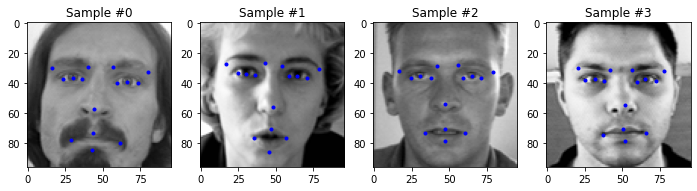

In [ ]:
#analyze and output points and images from the training dataset
show_images(train_data, range(4))

In [ ]:
def train_test_split(df_data, split): ### The function of sharing data for training validation
    df_data = df_data.sample(frac=1).reset_index(drop=True)#get a dataset
    len_data = len(df_data)#dataset size
    valid_split = int(len_data * split)
    train_split = int(len_data - valid_split)#training loaded values
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    return training_samples, valid_samples#return the necessary training values

In [ ]:
train_data = train_data.dropna() ### Usuwanie komórek
training_samples, valid_samples = train_test_split(train_data, 0.2) ###Split validation data for training

In [ ]:
class CreateDataset(Dataset): ### This class returns stripped input and output and converts a list of image and text pixels to a list as a number float.
    def __init__(self, dataframe, train=True, transform=None):
      #initialization parameters
        self.dataframe = dataframe
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class Normalize(object): ### Data merge
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255.,
                'keypoints': keypoints}

class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        image = image.reshape(1, IMG_SIZE, IMG_SIZE) #1 96 96
        image = torch.from_numpy(image)
        if keypoints is not None: ###If key points are provided, it turns them into a flare and returns a dictionary with an array of photos of the key points
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

Separate the training and test data and load them along with the dataset. Use DataLoader to iterate over the test and training data. (torch.utils.data.DataLoader)

In [ ]:
tsfm = transforms.Compose([Normalize(), ToTensor()]) ### A function that combines 2 types of data transformations

# Let's create a class object, put data for training into it, as well as an object with data transformation settings
trainset = CreateDataset(training_samples, transform=tsfm)
validnset = CreateDataset(valid_samples, transform=tsfm)
### The DataLoader will be applied to the trainset object. Retrieves data at 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                               )
valid_loader = torch.utils.data.DataLoader(validnset, batch_size=128,
                                               )

Design a convolutional network architecture for a regression problem. Use at least two convolution layers and at least one linear layer. Use the appropriate cost function, remembering that this is not a classification.

In [ ]:
class Face_cnn(nn.Module):#class for getting points

    def __init__(self, outputs=30):
        super(Face_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) ### Converts 1 image channel to 16 channels. 3 - kernel size
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) ###It goes through a 2 by 2 filter and selects the maximum value
        self.fc1 = nn.Linear(64*12*12, 1024) # The first layer of a conventional neural network
        self.fc2 = nn.Linear(1024, outputs) ### Transforms the input data
        self.dropout = nn.Dropout(0.3) ### Eliminate a percentage of neurons. Needed to weaken the effect of overtraining

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))

        return x


In [ ]:
device =torch.device('cuda')
model = Face_cnn(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
def train(train_loader, valid_loader, model, criterion, optimizer,
          n_epochs=50):

    valid_loss_min = np.Inf
    train_losses = []#
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0


        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*batch['image'].size(0)


        model.eval()
        for batch in valid_loader:
            output = model(batch['image'].to(device))
            # Obliczanie straty
            loss = criterion(output, batch['keypoints'].to(device))

            valid_loss += loss.item()*batch['image'].size(0)

       ###MSE
        train_loss = np.sqrt(train_loss/len(trainset))
        valid_loss = np.sqrt(valid_loss/len(validnset))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))



    return train_losses, valid_losses

Use the cost function values ​​to evaluate the model. Check the training and test set.

In [ ]:
train_losses, valid_losses = train(train_loader, valid_loader,
        model, criterion,
        optimizer, n_epochs=30)


Epoch: 1 	Training Loss: 4.110437 	Validation Loss: 3.361180
Epoch: 2 	Training Loss: 4.082832 	Validation Loss: 3.244187
Epoch: 3 	Training Loss: 4.012385 	Validation Loss: 3.210778
Epoch: 4 	Training Loss: 3.920636 	Validation Loss: 3.195058
Epoch: 5 	Training Loss: 3.888269 	Validation Loss: 3.199587
Epoch: 6 	Training Loss: 3.871031 	Validation Loss: 3.420018
Epoch: 7 	Training Loss: 3.873297 	Validation Loss: 3.270039
Epoch: 8 	Training Loss: 3.884188 	Validation Loss: 3.176307
Epoch: 9 	Training Loss: 3.773091 	Validation Loss: 3.183398
Epoch: 10 	Training Loss: 4.033363 	Validation Loss: 3.401463
Epoch: 11 	Training Loss: 3.990261 	Validation Loss: 3.422770
Epoch: 12 	Training Loss: 3.790203 	Validation Loss: 3.354056
Epoch: 13 	Training Loss: 3.760410 	Validation Loss: 3.234285
Epoch: 14 	Training Loss: 3.785148 	Validation Loss: 3.333145
Epoch: 15 	Training Loss: 3.798075 	Validation Loss: 3.185501
Epoch: 16 	Training Loss: 3.863872 	Validation Loss: 4.619929
Epoch: 17 	Traini

In [ ]:
def predict(data_loader, model):
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(data_loader):

            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df.reset_index(drop=True)], axis=1)
    show_images(pred_df.reset_index(drop=True), image_ids)  # Indeks obrazu zaczynający się od 1

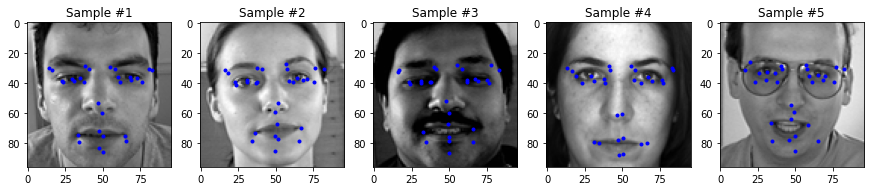

In [ ]:
# Loading minimal validation for model loss
predictions = predict(valid_loader, model)
columns = training_samples.drop('Image', axis=1).columns
view_pred_df(columns, valid_samples, predictions)